In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from Environment.E_commerce import *
from Environment.Product import *
from Algorithms.Conv_rates_Learner import *
from Algorithms.TS_Learner_poisson import *
from Algorithms.CG_Learner_Environment import *
from Algorithms.UCB_Learner import *
from Algorithms.Greedy_Learner import *
from Algorithms.CG_UCB_Learner import *
import copy

In [2]:
P1 = Product(0,[19.99, 21.99, 23.99, 26.99],np.multiply([0.2, 0.2, 0.2, 0.2],[19.99, 19.99, 19.99, 19.99])+[0, 21.99-19.99, 23.99-19.99, 26.99-19.99])
# t-shirt
P2 = Product(1,[29.99, 32.59, 35.99, 39.99],np.multiply([0.2, 0.2, 0.2, 0.2],[29.99, 29.99, 29.99, 29.99])+[29.99, 32.59, 35.99, 39.99]-29.99)
# shirt
P3 = Product(2,[25.99,28.99, 31.99, 34.99],np.multiply([0.3, 0.3, 0.3, 0.3],[25.99,25.99, 25.99, 25.99])+[25.99,28.99, 31.99, 34.99]-25.99)
# shorts
P4 = Product(3,[38.99,43.99,46.99, 49.99],np.multiply([0.4, 0.4, 0.4, 0.4],[38.99,38.99,38.99, 38.99])+[38.99,43.99,46.99, 49.99]-38.99)
# pants
P5 = Product(4,[79.99,89.99, 99.99, 109.99],np.multiply([0.5, 0.5, 0.5, 0.5],[79.99,79.99, 79.99, 79.99])+[79.99,89.99, 99.99, 109.99]-79.99)
# shoes
products = [P1,P2,P3,P4,P5]
margins_matrix = np.zeros((5,4))
expected_units_sold_per_product = np.array([2,1,3,3,1]) #theese are the lambdas defined in the visit function
for i in range(5):
    for j in range(4):
        margins_matrix[i,j] = products[i].margins_list[j]
E = CG_E_commerce()
E.set_lambda(0.5)
for f1 in range(2):
    for f2 in range(2):
        E.set_products(f1,f2,products)
E.graph = np.array([[0. , 0.5, 0. , 1. , 0. ],[1. , 0. , 0. , 0.5, 0. ],[0. , 1. , 0. , 0.5, 0. ],[0. , 0.5, 1. , 0. , 0. ],[1. , 0. , 0. , 0.5, 0. ]])


In [3]:
#Context generation for TS and random (reset every 2 weeks)

np.random.seed(1000)
n_arms = 4
num_users = 100
n_days = 14*10
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
num_experiments = 1
opt_vector = [[np.zeros(num_experiments) for _ in range(2)] for _ in range(2)]
conv_rates_per_experiment = [[[] for _ in range(2)] for _ in range(2)]
mean_units_sold_per_product_per_eperiment = [[[] for _ in range(2)] for _ in range(2)]
cr_learner_expected_rewards_per_experiment = [[[] for _ in range(2)] for _ in range(2)]
collected_reward_crs = np.array([])
collected_reward_tss = np.array([])

mu_c0_cr = [[0 for _ in range(2)] for _ in range(2)]
mu_c0_ts = [[0 for _ in range(2)] for _ in range(2)]
for e in range(num_experiments):
    env= CG_Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights,fixed_units)

    ## LEARN \mu0
    cr_learner = Conv_rates(n_arms=n_arms)
    ts_learner = TS_poisson(n_arms=n_arms)

    pulled_arm_cr = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
    pulled_arm_ts = [[np.zeros(5) for _ in range(2)] for _ in range(2)]

    split1_cr = 0
    split2_cr = 0

    split1_ts = 0
    split2_ts = 0

    for period in range(int(n_days/14)):
        print("period",period)
        for d in range(14):
            if split1_cr==0 and split2_cr==0:
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_cr[f1][f2] = cr_learner.pull_arm()

                reward_cr = env.round(pulled_arm_cr)  #reward_cr[f1][f2][i]
                cr_learner.update(pulled_arm_cr[0][0] , reward_cr[0][0], env.clicks_current_day[0][0], env.purchases_current_day[0][0],env.daily_units[0][0])

            # FIRST DECISION
            if split1_cr==1 and split2_cr==0:
                pulled_arm_cr = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_cr[f1][f2] = cr_learners[f1].pull_arm()

                reward_cr = env.round(pulled_arm_cr)

                for f1 in range(2):
                    cr_learners[f1].update(pulled_arm_cr[f1][0], (reward_cr[f1][0]+reward_cr[f1][1]), (env.clicks_current_day[f1][0]+env.clicks_current_day[f1][1]), (env.purchases_current_day[f1][0]+env.purchases_current_day[f1][1]),(env.daily_units[f1][0]+env.daily_units[f1][1]))

            elif split1_cr==1 and split2_cr==1:  # we add the second split
                pulled_arm_cr = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_cr[f1][f2] = cr_learners[f1][f2].pull_arm()

                reward_cr = env.round(pulled_arm_cr)

                for f1 in range(2):
                    for f2 in range(2):
                        cr_learners[f1][f2].update(pulled_arm_cr[f1][f2], reward_cr[f1][f2], env.clicks_current_day[f1][f2], env.purchases_current_day[f1][f2],env.daily_units[f1][f2])

            elif split1_cr == 0 and split2_cr ==1:
                pulled_arm_cr = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_cr[f1][f2] = cr_learners[f2].pull_arm()

                reward_cr = env.round(pulled_arm_cr)

                for f2 in range(2):
                    cr_learners[f2].update(pulled_arm_cr[0][f2], (reward_cr[0][f2]+reward_cr[1][f2]), (env.clicks_current_day[0][f2]+env.clicks_current_day[1][f2]), (env.purchases_current_day[0][f2]+env.purchases_current_day[1][f2]),(env.daily_units[0][f2]+env.daily_units[1][f2]))

        # --------------------------------------------------
        # -------------------THOMSON SAMPLING ---------------
        # --------------------------------------------------
        #ciao

            if split1_ts==0 and split2_ts==0:
                    for f1 in range(2):
                        for f2 in range(2):
                            pulled_arm_ts[f1][f2] = ts_learner.pull_arm(margins_matrix)

                    reward_ts = env.round(pulled_arm_ts)  #reward_ts[f1][f2][i]
                    ts_learner.update(pulled_arm_ts[0][0] , reward_ts[0][0], env.clicks_current_day[0][0], env.purchases_current_day[0][0],env.daily_units[0][0])

                # FIRST DECISION
            if split1_ts==1 and split2_ts==0:
                pulled_arm_ts = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_ts[f1][f2] = ts_learners[f1].pull_arm(margins_matrix)

                reward_ts = env.round(pulled_arm_ts)

                for f1 in range(2):
                    ts_learners[f1].update(pulled_arm_ts[f1][0], (reward_ts[f1][0]+reward_ts[f1][1]), (env.clicks_current_day[f1][0]+env.clicks_current_day[f1][1]), (env.purchases_current_day[f1][0]+env.purchases_current_day[f1][1]),(env.daily_units[f1][0]+env.daily_units[f1][1]))

            elif split1_ts==1 and split2_ts==1:  # we add the second split
                pulled_arm_ts = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_ts[f1][f2] = ts_learners[f1][f2].pull_arm(margins_matrix)

                reward_ts = env.round(pulled_arm_ts)

                for f1 in range(2):
                    for f2 in range(2):
                        ts_learners[f1][f2].update(pulled_arm_ts[f1][f2], reward_ts[f1][f2], env.clicks_current_day[f1][f2], env.purchases_current_day[f1][f2],env.daily_units[f1][f2])

            elif split1_ts == 0 and split2_ts ==1:
                pulled_arm_ts = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_ts[f1][f2] = ts_learners[f2].pull_arm(margins_matrix)

                reward_ts = env.round(pulled_arm_ts)

                for f2 in range(2):
                    ts_learners[f2].update(pulled_arm_ts[0][f2], (reward_ts[0][f2]+reward_ts[1][f2]), (env.clicks_current_day[0][f2]+env.clicks_current_day[1][f2]), (env.purchases_current_day[0][f2]+env.purchases_current_day[1][f2]),(env.daily_units[0][f2]+env.daily_units[1][f2]))




        # DECISION
        #compute sample probabilities and make decision
        if split1_cr==0 and split2_cr==0:
            mu_c0_cr[split1_cr][split2_cr] = np.sum(np.sum(cr_learner.rewards_per_arm))
            print('mu_c0_cr=',mu_c0_cr)
             # split 1
            collected_reward_crs=np.concatenate((collected_reward_crs, cr_learner.collected_rewards)) #axis=None
            #cr_learners = [cr_learner,cr_learner]
            cr_learners = [Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)]
            split1_cr = 1
            split2_cr = 0

        elif split1_cr==1 and split2_cr==0:
            P = env.E.users_by_class/np.sum(env.E.users_by_class)
            p_c1 = P[0][0] + P[0][1]
            p_c2 = P[1][0] + P[1][1]
            mu_c1 = np.sum(np.sum(cr_learners[0].rewards_per_arm))
            mu_c2 = np.sum(np.sum(cr_learners[1].rewards_per_arm))

            # we consider the second split
            mu_c0_cr[split1_cr][split2_cr] = p_c1*mu_c1 + p_c2*mu_c2
            split2_cr = 1  # in ogni caso consideremo la seconds feature
            print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)
            print('mu_c0_cr=',mu_c0_cr)
            collected_reward_crs=np.concatenate((collected_reward_crs,
                                                  cr_learners[0].collected_rewards + cr_learners[1].collected_rewards)) #axis=None
            if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_cr[0][0]:
                cr_learners = [[Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)] for _ in range(2)]
                split1_cr = 1
                print("--- SPLIT F1 MAKES SENSE ---")
            else:
                cr_learners = [Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)]
                split1_cr = 0
                print("--- SPLIT F1 DOESN'T MAKE SENSE ---")

        elif split1_cr==1 and split2_cr==1:
            P = env.E.users_by_class/np.sum(env.E.users_by_class)
            p_c1 = P[0][0] + P[1][0]  #p(seconda feature = 0)
            p_c2 = P[0][1] + P[1][1]  #p(seconda feature = 1)
            mu_c1 = np.sum(np.sum(cr_learners[0][0].rewards_per_arm))+np.sum(np.sum(cr_learners[1][0].rewards_per_arm))
            mu_c2 = np.sum(np.sum(cr_learners[0][1].rewards_per_arm))+np.sum(np.sum(cr_learners[1][1].rewards_per_arm))

            mu_c0_cr[split1_cr][split2_cr] = p_c1*mu_c1 + p_c2*mu_c2
            collected_reward_crs=np.concatenate((collected_reward_crs,
                                                  cr_learners[0][0].collected_rewards +
                                              cr_learners[0][1].collected_rewards +
                                              cr_learners[1][0].collected_rewards +
                                              cr_learners[1][1].collected_rewards )
                                              ) #axis=None

            print('mu_c0_cr=',mu_c0_cr)
            print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)

            if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_cr[1][0]:
                mu_c0_cr[split1_cr][split2_cr] = p_c1*mu_c1 + p_c2*mu_c2
                print("--- SPLIT F2 MAKES SENSE (together with f1)---")
            else:
                cr_learners = [Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)]
                split2_cr = 0
                print("--- SPLIT F2 DOESN'T MAKE SENSE (we consider only f1)---")

        elif split1_cr == 0 and split2_cr ==1:
            P = env.E.users_by_class/np.sum(env.E.users_by_class)
            p_c1 = P[0][0] + P[1][0]  #p(seconda feature = 0)
            p_c2 = P[0][1] + P[1][1]  #p(seconda feature = 1)
            mu_c1 = np.sum(np.sum(cr_learners[0].rewards_per_arm))
            mu_c2 = np.sum(np.sum(cr_learners[1].rewards_per_arm))

            mu_c0_cr[split1_cr][split2_cr] = p_c1*mu_c1 + p_c2*mu_c2

            # we consider the second split
            print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)
            print('mu_c0_cr=',mu_c0_cr)
            collected_reward_crs=np.concatenate((collected_reward_crs,
                                                  cr_learners[0].collected_rewards + cr_learners[1].collected_rewards)) #axis=None

            if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_cr[0][0]:
                mu_c0_cr[split1_cr][split2_cr] = p_c1*mu_c1 + p_c2*mu_c2
                print("--- SPLIT F2 MAKES SENSE (without f1)---")
                #cr_learners = [Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)]
            else:
                cr_learners = [Conv_rates(n_arms=n_arms)]
                split2_cr = 0
                print("--- SPLIT F2 DOESN'T MAKE SENSE (without f1) ---")

        
            # DECISION
        #compute sample probabilities and make decision
        if split1_ts==0 and split2_ts==0:
            mu_c0_ts[split1_ts][split2_ts] = np.sum(np.sum(ts_learner.rewards_per_arm))
            print('mu_c0_ts=',mu_c0_ts)
             # split 1
            collected_reward_tss=np.concatenate((collected_reward_tss, ts_learner.collected_rewards)) #axis=None
            #ts_learners = [ts_learner,ts_learner]
            ts_learners = [TS_poisson(n_arms=n_arms),TS_poisson(n_arms=n_arms)]
            split1_ts = 1
            split2_ts = 0

        elif split1_ts==1 and split2_ts==0:
            P = env.E.users_by_class/np.sum(env.E.users_by_class)
            p_c1 = P[0][0] + P[0][1]
            p_c2 = P[1][0] + P[1][1]
            mu_c1 = np.sum(np.sum(ts_learners[0].rewards_per_arm))
            mu_c2 = np.sum(np.sum(ts_learners[1].rewards_per_arm))

            # we consider the second split
            mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
            split2_ts = 1  # in ogni caso consideremo la seconds feature
            print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)
            print('mu_c0_ts=',mu_c0_ts)
            collected_reward_tss=np.concatenate((collected_reward_tss,
                                                  ts_learners[0].collected_rewards + ts_learners[1].collected_rewards)) #axis=None
            if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_ts[0][0]:
                ts_learners = [[TS_poisson(n_arms=n_arms),TS_poisson(n_arms=n_arms)] for _ in range(2)]
                split1_ts = 1
                print("--- SPLIT F1 MAKES SENSE ---")
            else:
                ts_learners = [TS_poisson(n_arms=n_arms),TS_poisson(n_arms=n_arms)]
                split1_ts = 0
                print("--- SPLIT F1 DOESN'T MAKE SENSE ---")

        elif split1_ts==1 and split2_ts==1:
            P = env.E.users_by_class/np.sum(env.E.users_by_class)
            p_c1 = P[0][0] + P[1][0]  #p(seconda feature = 0)
            p_c2 = P[0][1] + P[1][1]  #p(seconda feature = 1)
            mu_c1 = np.sum(np.sum(ts_learners[0][0].rewards_per_arm))+np.sum(np.sum(ts_learners[1][0].rewards_per_arm))
            mu_c2 = np.sum(np.sum(ts_learners[0][1].rewards_per_arm))+np.sum(np.sum(ts_learners[1][1].rewards_per_arm))

            mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
            collected_reward_tss=np.concatenate((collected_reward_tss,
                                                  ts_learners[0][0].collected_rewards +
                                              ts_learners[0][1].collected_rewards +
                                              ts_learners[1][0].collected_rewards +
                                              ts_learners[1][1].collected_rewards )
                                              ) #axis=None


            print('mu_c0_ts=',mu_c0_ts)
            print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)

            if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_ts[1][0]:
                mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
                print("--- SPLIT F2 MAKES SENSE (together with f1)---")
            else:
                ts_learners = [TS_poisson(n_arms=n_arms),TS_poisson(n_arms=n_arms)]
                split2_ts = 0
                print("--- SPLIT F2 DOESN'T MAKE SENSE (we consider only f1)---")

        elif split1_ts == 0 and split2_ts ==1:
            P = env.E.users_by_class/np.sum(env.E.users_by_class)
            p_c1 = P[0][0] + P[1][0]  #p(seconda feature = 0)
            p_c2 = P[0][1] + P[1][1]  #p(seconda feature = 1)
            mu_c1 = np.sum(np.sum(ts_learners[0].rewards_per_arm))
            mu_c2 = np.sum(np.sum(ts_learners[1].rewards_per_arm))

            mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2

            # we consider the second split
            print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)
            print('mu_c0_ts=',mu_c0_ts)
            collected_reward_tss=np.concatenate((collected_reward_tss,
                                                  ts_learners[0].collected_rewards + ts_learners[1].collected_rewards)) #axis=None

            if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_ts[0][0]:
                mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
                print("--- SPLIT F2 MAKES SENSE (without f1)---")
                #ts_learners = [Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)]
            else:
                ts_learners = [TS_poisson(n_arms=n_arms)]
                split2_ts = 0
                print("--- SPLIT F2 DOESN'T MAKE SENSE (without f1) ---")


period 0


c:\Users\Chris\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


mu_c0_cr= [[991.7485434897632, 0], [0, 0]]
mu_c0_ts= [[1542.6549078541384, 0], [0, 0]]
period 1
p_c1*mu_c1 + p_c2*mu_c2= 1460.588927446396
mu_c0_cr= [[991.7485434897632, 0], [1460.588927446396, 0]]
--- SPLIT F1 MAKES SENSE ---
p_c1*mu_c1 + p_c2*mu_c2= 2108.5440208769924
mu_c0_ts= [[1542.6549078541384, 0], [2108.5440208769924, 0]]
--- SPLIT F1 MAKES SENSE ---
period 2
mu_c0_cr= [[991.7485434897632, 0], [1460.588927446396, 1655.8602803421445]]
p_c1*mu_c1 + p_c2*mu_c2= 1655.8602803421445
--- SPLIT F2 MAKES SENSE (together with f1)---
mu_c0_ts= [[1542.6549078541384, 0], [2108.5440208769924, 2208.2321171144276]]
p_c1*mu_c1 + p_c2*mu_c2= 2208.2321171144276
--- SPLIT F2 MAKES SENSE (together with f1)---
period 3
mu_c0_cr= [[991.7485434897632, 0], [1460.588927446396, 3083.5677824746986]]
p_c1*mu_c1 + p_c2*mu_c2= 3083.5677824746986
--- SPLIT F2 MAKES SENSE (together with f1)---
mu_c0_ts= [[1542.6549078541384, 0], [2108.5440208769924, 4787.077235366093]]
p_c1*mu_c1 + p_c2*mu_c2= 4787.07723536609

In [5]:
P1 = Product(0,[19.99, 21.99, 23.99, 26.99],np.multiply([0.2, 0.2, 0.2, 0.2],[19.99, 19.99, 19.99, 19.99])+[0, 21.99-19.99, 23.99-19.99, 26.99-19.99])
# t-shirt
P2 = Product(1,[29.99, 32.59, 35.99, 39.99],np.multiply([0.2, 0.2, 0.2, 0.2],[29.99, 29.99, 29.99, 29.99])+[29.99, 32.59, 35.99, 39.99]-29.99)
# shirt
P3 = Product(2,[25.99,28.99, 31.99, 34.99],np.multiply([0.3, 0.3, 0.3, 0.3],[25.99,25.99, 25.99, 25.99])+[25.99,28.99, 31.99, 34.99]-25.99)
# shorts
P4 = Product(3,[38.99,43.99,46.99, 49.99],np.multiply([0.4, 0.4, 0.4, 0.4],[38.99,38.99,38.99, 38.99])+[38.99,43.99,46.99, 49.99]-38.99)
# pants
P5 = Product(4,[79.99,89.99, 99.99, 109.99],np.multiply([0.5, 0.5, 0.5, 0.5],[79.99,79.99, 79.99, 79.99])+[79.99,89.99, 99.99, 109.99]-79.99)
# shoes
products = [P1,P2,P3,P4,P5]
margins_matrix = np.zeros((5,4))
expected_units_sold_per_product = np.array([2,1,3,3,1]) #theese are the lambdas defined in the visit function
for i in range(5):
    for j in range(4):
        margins_matrix[i,j] = products[i].margins_list[j]
E = E_commerce(binary_features=1) #NORMAL ECOMMERCE
E.set_lambda(0.5)
E.set_products(products)
E.graph = np.array([[0. , 0.5, 0. , 1. , 0. ],[1. , 0. , 0. , 0.5, 0. ],[0. , 1. , 0. , 0.5, 0. ],[0. , 0.5, 1. , 0. , 0. ],[1. , 0. , 0. , 0.5, 0. ]])


In [36]:
#FIND OPTIMAL SOLUTION AND CONVERSION RATES
n_arms = 4
num_users = 100
n_days = 365
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
num_experiments = 10
opt_vector = np.zeros(num_experiments)
conv_rates_per_experiment = []
mean_units_sold_per_product_per_eperiment = []
cr_learner_expected_rewards_per_experiment = []

for e in range(num_experiments):
    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights,fixed_units)
    cr_learner = Conv_rates(n_arms=n_arms)

    for d in range(n_days):

        pulled_arm = cr_learner.pull_arm()#best_arm_per_product=np.array([2., 1., 1., 1., 0.]), clairvoyant_flag=1)
        reward = env.round(pulled_arm)
        cr_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day,env.daily_units)


    conversion_rates = np.zeros((5,4))
    np.set_printoptions(suppress=True)
    for i in range(5):
        conversion_rates[i] = cr_learner.beta_parameters[i][:,0]/(cr_learner.beta_parameters[i][:,0]+cr_learner.beta_parameters[i][:,1])
        opt_vector[e] += np.max(np.array(E.products[i].margins_list) * conversion_rates[i] * cr_learner.lambda_poisson[i])

    conv_rates_per_experiment.append(conversion_rates)
    mean_units_sold_per_product_per_eperiment.append(cr_learner.lambda_poisson)
    cr_learner_expected_rewards_per_experiment.append(cr_learner.expected_rewards)

#optimal expected clarvoyant solution is given chosing each round the best combination
opt = np.mean(opt_vector) #+ np.std(opt_vector)
best_arm_per_product = np.zeros(5)
for i in range(5):   
    best_arm_per_product[i] = np.argmax(np.array(E.products[i].margins_list) * np.mean(conv_rates_per_experiment,axis=0)[i] 
                                        * np.mean(mean_units_sold_per_product_per_eperiment, axis = 0)[i])#expected_units_sold_per_product[i])#
    
print("_______________________________________________")
print("Conversion rates")
print(np.mean(conv_rates_per_experiment,axis=0))
print("_______________________________________________")
print("Expected rewards per arm")
print(np.mean(cr_learner_expected_rewards_per_experiment,axis=0))
print("_______________________________________________")
print("Expected units sold per arm")
print(np.mean(mean_units_sold_per_product_per_eperiment, axis = 0))

print("_______________________________________________")
print("Best configuration", best_arm_per_product)
print("Optimal cumulative expected reward per round")
print(opt) # optimal configuration: the best combination of arms

_______________________________________________
Conversion rates
[[0.97968167 0.7578817  0.24918    0.00706328]
 [0.97225802 0.75536942 0.1458091  0.005492  ]
 [0.99379579 0.85317283 0.2342909  0.01035883]
 [0.9918271  0.74258552 0.32504387 0.0469129 ]
 [0.99447749 0.94541047 0.48169938 0.04648316]]
_______________________________________________
Expected rewards per arm
[[ 7.95919868  9.18553199  3.89855614  0.06738779]
 [ 5.85140852  6.55536165  1.70470844  0.02536301]
 [23.42083559 27.43759035  9.84384995  0.30868084]
 [46.68585897 46.64430417 23.60436088  3.73347109]
 [39.995      47.50205558 28.88668007  2.91321748]]
_______________________________________________
Expected units sold per arm
[[2.01952311 2.02777283 2.00542056 1.19625   ]
 [1.         1.         1.         0.3       ]
 [3.00886969 2.96198763 3.07878972 2.40057864]
 [3.00461319 3.04829288 3.0663404  3.13278023]
 [1.         1.         1.         1.        ]]
_______________________________________________
Best confi

In [37]:
opt,best_arm_per_product

(138.4389871146141, array([1., 1., 1., 1., 1.]))

In [29]:
#1 CLASS, TS for first two weeks

E = E_commerce(binary_features=10)
E.set_lambda(0.5)
E.set_products(products)
E.graph = np.array([[0. , 0.5, 0. , 1. , 0. ],[1. , 0. , 0. , 0.5, 0. ],[0. , 1. , 0. , 0.5, 0. ],[0. , 0.5, 1. , 0. , 0. ],[1. , 0. , 0. , 0.5, 0. ]])

n_arms = 4
num_users = 1000
n_days = 14
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
n_experiments = 10

ts1_rewards_per_experiment = []


ts1_pulls_per_arm_per_experiment = []


for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ts_learner = TS_poisson(n_arms=n_arms)

    for d in range(n_days):
        
        pulled_arm = ts_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        ts_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day, env.daily_units)

    ts1_rewards_per_experiment.append(ts_learner.collected_rewards)

    ts1_pulls_per_arm_per_experiment.append(ts_learner.counter_per_arm)

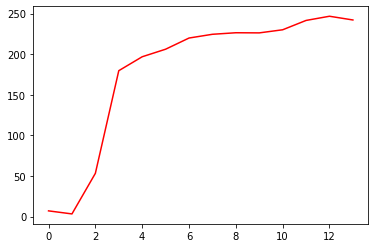

In [30]:
plt.plot(np.cumsum(opt-np.mean(ts1_rewards_per_experiment,axis=0), axis=0), 'r')

In [39]:
#TS class 0 + 1 for two weeks


E = E_commerce(binary_features=20)
E.set_lambda(0.5)
E.set_products(products)
E.graph = np.array([[0. , 0.5, 0. , 1. , 0. ],[1. , 0. , 0. , 0.5, 0. ],[0. , 1. , 0. , 0.5, 0. ],[0. , 0.5, 1. , 0. , 0. ],[1. , 0. , 0. , 0.5, 0. ]])

n_arms = 4
num_users = 70*3
n_days = 14
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
n_experiments = 10

ts2_rewards_per_experiment = []


ts2_pulls_per_arm_per_experiment = []



for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ts_learner = TS_poisson(n_arms=n_arms)

    for d in range(n_days):
        
        pulled_arm = ts_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        ts_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day, env.daily_units)

    ts2_rewards_per_experiment.append(ts_learner.collected_rewards)

    ts2_pulls_per_arm_per_experiment.append(ts_learner.counter_per_arm)



E = E_commerce(binary_features=10)
E.set_lambda(0.5)
E.set_products(products)
E.graph = np.array([[0. , 0.5, 0. , 1. , 0. ],[1. , 0. , 0. , 0.5, 0. ],[0. , 1. , 0. , 0.5, 0. ],[0. , 0.5, 1. , 0. , 0. ],[1. , 0. , 0. , 0.5, 0. ]])

n_arms = 4
num_users = 30*3
n_days = 14
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
n_experiments = 10

ts1_rewards_per_experiment = []


ts1_pulls_per_arm_per_experiment = []


for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ts_learner = TS_poisson(n_arms=n_arms)

    for d in range(n_days):
        
        pulled_arm = ts_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        ts_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day, env.daily_units)

    ts1_rewards_per_experiment.append(ts_learner.collected_rewards)

    ts1_pulls_per_arm_per_experiment.append(ts_learner.counter_per_arm)


In [40]:
ts_reward_first_split = 0.3*(np.mean(ts1_rewards_per_experiment, axis=0))+0.7*(np.mean(ts2_rewards_per_experiment, axis=0))

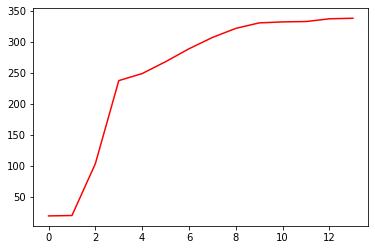

In [41]:

plt.plot(np.cumsum(opt-ts_reward_first_split, axis=0), 'r')

In [31]:
#TS class 0 + 1 + 2 for tot days

E = E_commerce(binary_features=30)
E.set_lambda(0.5)
E.set_products(products)
E.graph = np.array([[0. , 0.5, 0. , 1. , 0. ],[1. , 0. , 0. , 0.5, 0. ],[0. , 1. , 0. , 0.5, 0. ],[0. , 0.5, 1. , 0. , 0. ],[1. , 0. , 0. , 0.5, 0. ]])

n_arms = 4
num_users = 30*3
n_days = 300
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
n_experiments = 10

ts3_rewards_per_experiment = []


ts3_pulls_per_arm_per_experiment = []



for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ts_learner = TS_poisson(n_arms=n_arms)

    for d in range(n_days):
        
        pulled_arm = ts_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        ts_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day, env.daily_units)

    ts3_rewards_per_experiment.append(ts_learner.collected_rewards)

    ts3_pulls_per_arm_per_experiment.append(ts_learner.counter_per_arm)




E = E_commerce(binary_features=20)
E.set_lambda(0.5)
E.set_products(products)
E.graph = np.array([[0. , 0.5, 0. , 1. , 0. ],[1. , 0. , 0. , 0.5, 0. ],[0. , 1. , 0. , 0.5, 0. ],[0. , 0.5, 1. , 0. , 0. ],[1. , 0. , 0. , 0.5, 0. ]])

n_arms = 4
num_users = 40*3
n_days = 300
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
n_experiments = 10

ts2_rewards_per_experiment = []


ts2_pulls_per_arm_per_experiment = []



for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ts_learner = TS_poisson(n_arms=n_arms)

    for d in range(n_days):
        
        pulled_arm = ts_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        ts_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day, env.daily_units)

    ts2_rewards_per_experiment.append(ts_learner.collected_rewards)

    ts2_pulls_per_arm_per_experiment.append(ts_learner.counter_per_arm)



E = E_commerce(binary_features=10)
E.set_lambda(0.5)
E.set_products(products)
E.graph = np.array([[0. , 0.5, 0. , 1. , 0. ],[1. , 0. , 0. , 0.5, 0. ],[0. , 1. , 0. , 0.5, 0. ],[0. , 0.5, 1. , 0. , 0. ],[1. , 0. , 0. , 0.5, 0. ]])

n_arms = 4
num_users = 30*3
n_days = 300
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
n_experiments = 10

ts1_rewards_per_experiment = []


ts1_pulls_per_arm_per_experiment = []


for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ts_learner = TS_poisson(n_arms=n_arms)

    for d in range(n_days):
        
        pulled_arm = ts_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        ts_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day, env.daily_units)

    ts1_rewards_per_experiment.append(ts_learner.collected_rewards)

    ts1_pulls_per_arm_per_experiment.append(ts_learner.counter_per_arm)


In [9]:
print("TS",np.mean(np.mean(ts1_rewards_per_experiment, axis=0)), np.std(np.mean(ts1_rewards_per_experiment, axis=0)))
print("TS",np.mean(np.mean(ts2_rewards_per_experiment, axis=0)), np.std(np.mean(ts2_rewards_per_experiment, axis=0)))
print("TS",np.mean(np.mean(ts3_rewards_per_experiment, axis=0)), np.std(np.mean(ts3_rewards_per_experiment, axis=0)))

ts_all_classes_rewards = 0.3*(np.mean(ts1_rewards_per_experiment, axis=0))+0.4*(np.mean(ts2_rewards_per_experiment, axis=0))+0.3*np.mean(ts3_rewards_per_experiment, axis=0)


TS 130.11246428571428 25.77514579779922
TS 128.78559654761906 25.283739464728942
TS 129.06082589285714 26.306926841454207


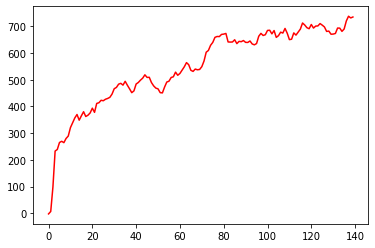

In [12]:
plt.plot(np.cumsum(opt-ts_all_classes_rewards, axis=0), 'r')

UCB

In [50]:
#TS class 0 + 1 + 2 for tot days

E = E_commerce(binary_features=30)
E.set_lambda(0.5)
E.set_products(products)
E.graph = np.array([[0. , 0.5, 0. , 1. , 0. ],[1. , 0. , 0. , 0.5, 0. ],[0. , 1. , 0. , 0.5, 0. ],[0. , 0.5, 1. , 0. , 0. ],[1. , 0. , 0. , 0.5, 0. ]])

n_arms = 4
num_users = 30*3
n_days = 300
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
n_experiments = 10

ts3_rewards_per_experiment = []


ts3_pulls_per_arm_per_experiment = []



for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ts_learner = UCB(n_arms=n_arms)

    for d in range(n_days):
        
        pulled_arm = ts_learner.pull_arm()
        reward = env.round(pulled_arm)
        ts_learner.update(pulled_arm, reward)

    ts3_rewards_per_experiment.append(ts_learner.collected_rewards)

    ts3_pulls_per_arm_per_experiment.append(ts_learner.counter_per_arm)




E = E_commerce(binary_features=20)
E.set_lambda(0.5)
E.set_products(products)
E.graph = np.array([[0. , 0.5, 0. , 1. , 0. ],[1. , 0. , 0. , 0.5, 0. ],[0. , 1. , 0. , 0.5, 0. ],[0. , 0.5, 1. , 0. , 0. ],[1. , 0. , 0. , 0.5, 0. ]])

n_arms = 4
num_users = 40*3
n_days = 300
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
n_experiments = 10

ts2_rewards_per_experiment = []


ts2_pulls_per_arm_per_experiment = []



for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ts_learner = UCB(n_arms=n_arms)

    for d in range(n_days):
        
        pulled_arm = ts_learner.pull_arm()
        reward = env.round(pulled_arm)
        ts_learner.update(pulled_arm, reward)

    ts2_rewards_per_experiment.append(ts_learner.collected_rewards)

    ts2_pulls_per_arm_per_experiment.append(ts_learner.counter_per_arm)



E = E_commerce(binary_features=10)
E.set_lambda(0.5)
E.set_products(products)
E.graph = np.array([[0. , 0.5, 0. , 1. , 0. ],[1. , 0. , 0. , 0.5, 0. ],[0. , 1. , 0. , 0.5, 0. ],[0. , 0.5, 1. , 0. , 0. ],[1. , 0. , 0. , 0.5, 0. ]])

n_arms = 4
num_users = 30*3
n_days = 300
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
n_experiments = 10

ts1_rewards_per_experiment = []


ts1_pulls_per_arm_per_experiment = []


for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ts_learner = UCB(n_arms=n_arms)

    for d in range(n_days):
        
        pulled_arm = ts_learner.pull_arm()
        reward = env.round(pulled_arm)
        ts_learner.update(pulled_arm, reward)

    ts1_rewards_per_experiment.append(ts_learner.collected_rewards)

    ts1_pulls_per_arm_per_experiment.append(ts_learner.counter_per_arm)


In [51]:
print("TS",np.mean(np.mean(ts1_rewards_per_experiment, axis=0)), np.std(np.mean(ts1_rewards_per_experiment, axis=0)))
print("TS",np.mean(np.mean(ts2_rewards_per_experiment, axis=0)), np.std(np.mean(ts2_rewards_per_experiment, axis=0)))
print("TS",np.mean(np.mean(ts3_rewards_per_experiment, axis=0)), np.std(np.mean(ts3_rewards_per_experiment, axis=0)))

ts_all_classes_rewards = 0.3*(np.mean(ts1_rewards_per_experiment, axis=0))+0.4*(np.mean(ts2_rewards_per_experiment, axis=0))+0.3*np.mean(ts3_rewards_per_experiment, axis=0)


TS 133.90551109761907 13.195978583956622
TS 133.07079590396825 14.250208422710083
TS 109.41897216111111 16.134062782483404


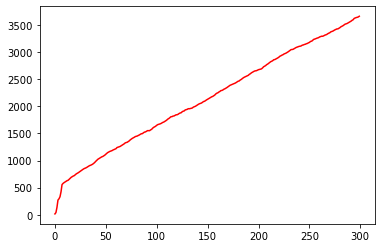

In [52]:
plt.plot(np.cumsum(opt-ts_all_classes_rewards, axis=0), 'r')